## 네이버 영화리뷰 감성분석

### 학습 목표
- 텍스트 데이터를 머신러닝 입출력용 수치데이터로 변환하는 과정을 이해한다.
- RNN의 특징을 이해하고 Sequantial한 데이터를 다루는 방법을 이해한다.
- 1-D CNN으로도 텍스트를 처리할 수 있음을 이해한다.
- IMDB와 네이버 영화리뷰 데이터셋을 이용한 영화리뷰 감성 분류 실습을 진행한다.

### 루브릭 
- 다양한 방법으로 Test Classification 테스크를 성공적으로 구현하였다: **3가지 이상의 모델이 성공적으로 시도됨**
- gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다: **gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 적절히 분석함**
- 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.: **네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함**

## 목차
### 1. 데이터 준비와 텍스트 인덱스화
### 2. 모델 구성을 위한 데이터 가공
### 3. 모델 및 validation set 구성
### 4. 모델 훈련과 Loss, Accuracy 분석
### 5. 학습된 Embedding 레이어 분석
### 6. 한국어 Word2Vec 임베딩 활용하여 성능 개선
---

## 1. 데이터 준비와 텍스트 인덱스화

In [1]:
import pandas as pd

train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [2]:
print(len(train_data))
print(len(test_data))

150000
50000


In [3]:
train_data.drop_duplicates(subset = ['document'], inplace = True)
train_data = train_data.dropna(how = 'any') 
test_data.drop_duplicates(subset=['document'], inplace=True)
test_data = test_data.dropna(how = 'any')

print(len(train_data))
print(len(test_data))

146182
49157


train 15만개, test 5만개 총 20만개의 영화 리뷰를 긍정 1, 부정 0으로 라벨링한 데이터를 로드한다. 중복데이터를 제거하고, 결측값을 삭제하여 train 146182개, test 49157개가 남았다.

* drop_duplicates()는 DataFrame에서 중복값을 제거한다.
  * subset: 중복을 찾을 column 지정 (default: all columns)
  * keep: 중복값들 중 어떤 값을 남겨둘지 결정{'first', 'last', False:모두 지움},  (default 'first')
  * inplace: 중복 제거를 DataFrame에 반영할지 결정{True:반영, False:반영하지 않고 copy를 반환} (default False)

* dropna()는 DataFrame에서 결측값을 제거한다.
  * axis: 결측값을 row에서 찾을 지 column에서 찾을 지 결정{0: row 1: column} (default 0)
  * how: 결측값 제거 기준 결정{'any': 결측이 하나라도 있을 시 삭제, 'all': 모든 값이 결측값일 때 삭제} (default 'any')

In [4]:
from konlpy.tag import Mecab

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

오픈소스 형태소 분석기들을 파이썬 환경에서 사용할 수 있도록 한 한국어 자연어 처리 패키지 [KoNLPy](http://konlpy.org/en/latest)에서 형태소 분석기 Mecab을 import하고 tokenizer로 정의한다. 

또한 불용어(stopwords)를 정의한다. 주로 한국어 조사들을 불용어로 지정하는데, 문장에 나타나는 빈도가 너무 높아 목적에 맞는 주요한 단어를 찾는데에 방해가 되기 때문이다.

In [5]:
import numpy as np
from collections import Counter

def load_data(train_data, test_data, num_words):
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence)    # 문장을 토큰화
        temp_X = [word for word in temp_X if not word in stopwords]    # 토큰화 된 단어 중 불용어가 아닌 것만 tmp_X 리스트에 담음
        X_train.append(temp_X) 
        
    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()   
    counter = Counter(words)   
    counter = counter.most_common(num_words-4)  
    vocab = ['', '', '', ''] + [key for key, _ in counter]  
    word_to_index = {word:index for index, word in enumerate(vocab)}
    word_to_index["<PAD>"] = 0
    word_to_index["<BOS>"] = 1
    word_to_index["<UNK>"] = 2  # unknown
    word_to_index["<UNUSED>"] = 3


    def wordlist_to_indexlist(wordlist): 
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

train, test 데이터와 저장할 단어의 수를 입력받아 텍스트를 토큰화한 다음, 불용어를 제거하여 word_to_index 딕셔너리를 구성, 데이터를 숫자 인덱스로 변환하는 함수를 선언한다. 함수의 각 구성에서 수행하는 작업은 다음과 같다.

---
**1. 문장을 토큰화하고 그 중 불용어가 아닌 단어만 골라 temp_X 리스트에 담고, 문장의 단어주머니인 temp_X를 X_train 리스트에 담는다.(이중 리스트) 같은 과정을 X_test에서도 수행한다.** 
```python
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        X_train.append(temp_X) 
```
   
**2. X_train에서 저장한 모든 단어들을 words 리스트에 담고, 자주 나온 단어들을 단어 사전에 추가 한다.** 
```python
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)} 
```
* np.concatenate는 Numpy 배열들을 하나로 합친다. X_train에 담긴 리스트들을 하나로 합친 배열을 tolist() 함수를 통해 리스트로 변경한다.
* Counter(a)는 입력받은 리스트 a에서 요소들의 갯수를 세어 {단어:갯수} 딕셔너리로 반환한다.
  * Counter(a).most)common(n): a의 요소들 중 최빈값 n개만 골라 (단어, 갯수) 튜플로 반환한다.
* vocab 리스트에 \<PAD\>, \<BOS\>, \<UNK\>, \<UNUSED\>가 들어갈 4개의 공백을 두고 가장 자주 나온 단어 num_words-4개를 저장한 다음, word_to_index에 {단어:인덱스} 딕셔너리로 저장한다.

**3. X_train과 X_test에 저장된 단어 리스트들을 인덱스 리스트들로 변경한다.** 
```python
def wordlist_to_indexlist(wordlist): 
    return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
X_train = list(map(wordlist_to_indexlist, X_train))
```
* 입력받은 wordlist에 들어있는 단어가 'word_to_index' 딕셔너리에 들어있다면 그 인덱스를, 그렇지 않으면 '\<UNK\>'의 인덱스를 반환하는 함수 wordlist_to_indexlist 함수를 내부함수로 선언한다.
* map 함수를 통해 X_train에 들어있는 모든 단어 주머니들에 대해 wordlist_to_indexlist 함수를 적용한다.

---

In [6]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data, num_words = 12000) 
index_to_word = {index:word for word, index in word_to_index.items()}

함수 load_data를 통해 12000개 단어로 이루어진 word_to_index 딕셔너리를 정의하여 X_train과 X_test의 문장들을 모두 숫자 벡터로 변환하였고, 불러온 word_to_index에서 index_to_word 딕셔너리를 정의한다.

In [7]:
# 문장 1개를 단어 인덱스 리스트(벡터)로 encode하는 함수
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']] + [word_to_index[word] 
                                       if word in word_to_index else word_to_index['<UNK>'] 
                                       for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트(벡터)로 encode하는 함수
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터 1개를 문장으로 decode하는 함수
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] 
                    if index in index_to_word else '<UNK>' for index in encoded_sentence)    

# 여러 개의 숫자 벡터를 한꺼번에 문장으로 decode하는 함수
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentences, index_to_word) for encoded_sentence in encoded_sentences]

In [8]:
for i in range(10):
    print(X_train[i], '\n', get_decoded_sentence(X_train[i], index_to_word), '\n', y_train[i])

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748] 
 아 더 빙 . . 진짜 짜증 나 네요 목소리 
 0
[1028, 4, 11, 519, 549, 687, 5, 120, 4, 70, 1639, 52, 925, 1006, 15, 44, 391] 
 흠 . .. 포스터 보고 초딩 영화 줄 . ... 오버 연기 조차 가볍 지 않 구나 
 1
[24, 205, 2] 
 너무 재 <UNK> 
 0
[8409, 158, 3925, 4, 4, 298, 94, 17, 6, 4, 4, 58, 3479] 
 교도소 이야기 구먼 . . 솔직히 재미 없 다 . . 평점 조정 
 0
[2, 8894, 1108, 52, 2832, 60, 5, 14, 2758, 41, 1188, 35, 351, 42, 22, 40, 60, 2, 2, 427, 3102, 1766, 6] 
 <UNK> 익살 스런 연기 돋보였 던 영화 ! 스파이더맨 에서 늙 어 보이 기 만 했 던 <UNK> <UNK> 너무나 이뻐 보였 다 
 1
[675, 2, 2, 131, 420, 185, 1547, 712, 65, 1694, 715, 53, 375, 192, 271, 5, 4, 69, 4, 11, 2179, 122, 750, 4] 
 막 <UNK> <UNK> 3 세 부터 초등 학교 1 학년 생 인 8 살 용 영화 . ㅋㅋㅋ . .. 별반 개 아까움 . 
 0
[253, 381, 9, 384, 2012, 55, 15, 817, 6, 4] 
 원작 긴장감 을 제대로 살려 내 지 못했 다 . 
 0
[232, 1450, 144, 6, 425, 756, 10855, 2, 52, 1532, 290, 99, 250, 4, 4, 28, 855, 29, 353, 652, 540, 509, 583, 6, 3318, 4, 8895, 22, 1460, 1460, 4, 4, 71, 304, 17, 6, 52, 104, 8, 77, 22, 2, 43] 
 별 반개 아깝 다 욕 나온다 이응경 <UNK> 연기 생활 몇

두 딕셔너리를 이용하여 문장을 숫자 벡터로 encode하는 함수와 숫자 벡터를 문장으로 decode 하는 함수를 선언하였다. 문장의 인덱스화가 잘 되었는지 데이터의 일부분을 호출해 확인한다. word_to_index가 저장하는 최대 단어수가 제한되어 있어, 일부 단어들은 인덱스 과정에서 소실되었다.('\<UNK\>'로 대체됨)

## 2. 모델 구성을 위한 데이터 가공

In [9]:
total_data_text = X_train + X_test

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장 단어 수 평균 : ', np.mean(num_tokens))
print('문장 단어 수 중앙값 : ', np.median(num_tokens))
print('문장 단어 수 최대 : ', np.max(num_tokens))
print('문장 단어 수 표준편차 : ', np.std(num_tokens))

문장 단어 수 평균 :  15.96940191154864
문장 단어 수 중앙값 :  12.0
문장 단어 수 최대 :  116
문장 단어 수 표준편차 :  12.843571191092


숫자로 endocing된 train과 test 문장들이 각각 토큰을 몇개 가지고 있는지 각 문장을 tokens로 불러와 len(tokens)로 토큰수를 나타내어 num_tokens에 리스트로 저장한 다음 np.array로 변경한다.

np.array num_tokens에 numpy의 메서드 mean, max, std를 적용하여 보유한 문장들의 단어 수 평균, 중앙값, 최대, 표준편차를 계산한다. 평균과 중앙값이 큰 차이가 나지 않는 것으로 보아 116개의 단어로 이루어진 최대 길이 문장과 같은 outlier가 많지 않음을 추측할 수 있다.

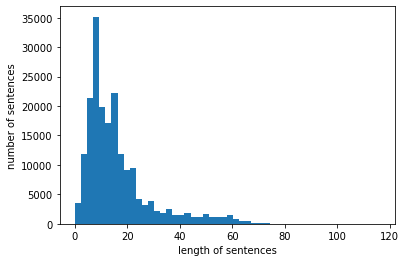

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist([len(tokens) for tokens in total_data_text], bins=50)
plt.xlabel('length of sentences')
plt.ylabel('number of sentences')
plt.show()

In [11]:
maxlen = 50
print('최대 문장 길이 : ', maxlen)
print('전체 문장의 {}%가 최대 문장 길이 이내에 포함 '.format(np.sum(num_tokens < maxlen) / len(num_tokens)))

최대 문장 길이 :  50
전체 문장의 0.957432975493885%가 최대 문장 길이 이내에 포함 


문장의 길이 분포를 시각화해 보고, 대부분의 문장을 모두 포괄할 수 있는 최대 문장 길이를 50으로 지정하였다.

In [12]:
import tensorflow as tf

X_train_pad = tf.keras.preprocessing.sequence.pad_sequences(X_train, value=word_to_index["<PAD>"], padding='pre', maxlen=maxlen)

X_test_pad = tf.keras.preprocessing.sequence.pad_sequences(X_test, value=word_to_index["<PAD>"], padding='pre', maxlen=maxlen)

print(X_train_pad.shape)
print(X_test_pad.shape)

(146182, 50)
(49157, 50)


최대 문장 길이보다 짧은 문장에 padding을 시행하여 길이를 맞춰준다. 입력데이터가 순차적으로 처리되는 RNN 모델을 고려해 pre-padding을 시행한다.

### 3) 모델 구성 및 validation set 구성

In [13]:
# RNN(LSTM) 모델

vocab_size = 12000    # 어휘 사전의 크기
word_vector_dim = 16    # 단어 벡터의 차원수(모든 모델에 동일하게 적용)

model_RNN = tf.keras.Sequential()
model_RNN.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape = (None,)))
model_RNN.add(tf.keras.layers.LSTM(8))    
model_RNN.add(tf.keras.layers.Dense(8, activation = 'relu'))    
model_RNN.add(tf.keras.layers.Dense(1, activation = 'sigmoid')) 

model_RNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          192000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 192,881
Trainable params: 192,881
Non-trainable params: 0
_________________________________________________________________


In [14]:
# CNN 모델

model_CNN = tf.keras.Sequential()
model_CNN.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_CNN.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_CNN.add(tf.keras.layers.MaxPooling1D(5))
model_CNN.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_CNN.add(tf.keras.layers.GlobalMaxPooling1D())
model_CNN.add(tf.keras.layers.Dense(8, activation='relu'))
model_CNN.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_CNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          192000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [15]:
# 1-Layer CNN 모델

model_CNN_simple = tf.keras.Sequential()
model_CNN_simple.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_CNN_simple.add(tf.keras.layers.GlobalMaxPooling1D())
model_CNN_simple.add(tf.keras.layers.Dense(8, activation='relu'))
model_CNN_simple.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_CNN_simple.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          192000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 192,145
Trainable params: 192,145
Non-trainable params: 0
_________________________________________________________________


RNN, CNN, 1-layer CNN을 각각 구성하였다. 모든 모델은 입력받은 어휘량(vocab_size)이 같고, 단어를 벡터화 했을 때의 차원수(word_vector_dim) 또한 같다. 그러므로 첫번째 레이어인 embedding 레이어가 모두 같다. 

딥러닝으로 문장 데이터를 학습할 때, 단어의 의미를 나타내는 벡터를 훈련 가능한 파라미터로 사용하기 위해 이러한 의미 벡터 파라미터를 구현한 레이어가 필요하게 되는데 이것이 embedding 레이어의 역할이다. 즉, 세 모델에게 단어의 의미 파라미터는 모두 같다.

각 모델의 차이점:
* RNN: 시간의 흐름에 따라 새롭게 들어오는 입력에 따라 변하는 현재 상태를 묘사하는 state machine으로 설계된 모델이다. 이전 시점에 나온 단어나 문장이 다음, 그 다음 단어나 문장에 영향을 주는 텍스트 데이터에 적합한 딥러닝 모델로 알려져있다.
* CNN: 문장 전체를 한꺼번에 한 방향으로 길이 7짜리 필터로 스캐닝 하면서 7단어 이내에서 발견되는 특징을 추출하여 그것으로 문장을 분류한다. RNN 계열보다 병렬처리가 효율적이기 때문에 학습 속도에 이점이 있다.
* 1-layer CNN: CNN 모델에서 GlobalMaxPooling1D() 레이어 하나만 사용하는 방법으로, 전체 문장 중에서 단 하나의 가장 중요한 단어만 피처로 추출하여 문장의 긍정/부정을 평가하는 방식이다. 영화 리뷰의 문장 길이는 길지 않은 편이므로, 빠른 분류에 효율적으로 사용할 수 있다.

In [16]:
val = int(len(X_train_pad)*0.25)

X_val = X_train_pad[:val]   
y_val = y_train[:val]

# validation set을 제외한 나머지
partial_X_train = X_train_pad[val:]  
partial_y_train = y_train[val:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(109637, 50)
(109637,)


X_train의 25%만큼을 validation set으로 분할한다.(일반적으로 train set의 20~30%를 validation set으로 삼고, train:test 비율 또한 3(75%):1(25%)이므로)

## 4. 모델 훈련과 Loss, Accuracy 분석

In [17]:
def model_learning(model, epochs):

    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    model_history = model.fit(partial_X_train, partial_y_train, epochs=epochs, 
                            batch_size=512, validation_data=(X_val, y_val), verbose=1)
    results = model.evaluate(X_test_pad,  y_test, verbose=2)
    print(results)
    
    history_dict = model_history.history
    
    fig = plt.figure()
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)
    
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)

    ax1.plot(epochs, loss, 'bo', label='Training loss')
    ax1.plot(epochs, val_loss, 'b', label='Validation loss')
    ax1.set_title('Training and validation loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    ax2.plot(epochs, acc, 'bo', label='Training acc')
    ax2.plot(epochs, val_acc, 'b', label='Validation acc')
    ax2.set_title('Training and validation accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.show()

모델과 epochs를 입력받으면 모델이 학습을 진행하여 test 데이터에 대한 accuracy를 계산하고, history_dict에 epoch 당 accuracy와 loss를 계산하여 저장 후 시각화하는 함수를 선언하였다.

Epoch 1/10
215/215 [==============================] - 5s 9ms/step - loss: 0.5141 - accuracy: 0.7740 - val_loss: 0.3781 - val_accuracy: 0.8426
Epoch 2/10
215/215 [==============================] - 1s 6ms/step - loss: 0.3420 - accuracy: 0.8588 - val_loss: 0.3465 - val_accuracy: 0.8516
Epoch 3/10
215/215 [==============================] - 1s 6ms/step - loss: 0.3076 - accuracy: 0.8741 - val_loss: 0.3434 - val_accuracy: 0.8535
Epoch 4/10
215/215 [==============================] - 1s 6ms/step - loss: 0.2899 - accuracy: 0.8830 - val_loss: 0.3488 - val_accuracy: 0.8528
Epoch 5/10
215/215 [==============================] - 1s 6ms/step - loss: 0.2774 - accuracy: 0.8886 - val_loss: 0.3555 - val_accuracy: 0.8511
Epoch 6/10
215/215 [==============================] - 1s 6ms/step - loss: 0.2643 - accuracy: 0.8949 - val_loss: 0.3595 - val_accuracy: 0.8497
Epoch 7/10
215/215 [==============================] - 1s 6ms/step - loss: 0.2534 - accuracy: 0.8997 - val_loss: 0.3724 - val_accuracy: 0.8462
Epoch 

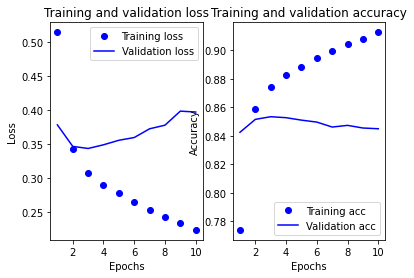

In [18]:
model_learning(model_RNN, 10)

Epoch 1/10
215/215 [==============================] - 3s 6ms/step - loss: 0.5949 - accuracy: 0.6680 - val_loss: 0.4738 - val_accuracy: 0.7587
Epoch 2/10
215/215 [==============================] - 1s 5ms/step - loss: 0.4455 - accuracy: 0.7805 - val_loss: 0.4579 - val_accuracy: 0.7652
Epoch 3/10
215/215 [==============================] - 1s 5ms/step - loss: 0.4125 - accuracy: 0.7996 - val_loss: 0.4654 - val_accuracy: 0.7653
Epoch 4/10
215/215 [==============================] - 1s 5ms/step - loss: 0.3886 - accuracy: 0.8121 - val_loss: 0.4646 - val_accuracy: 0.7707
Epoch 5/10
215/215 [==============================] - 1s 5ms/step - loss: 0.3640 - accuracy: 0.8257 - val_loss: 0.4738 - val_accuracy: 0.7686
Epoch 6/10
215/215 [==============================] - 1s 5ms/step - loss: 0.3361 - accuracy: 0.8422 - val_loss: 0.4944 - val_accuracy: 0.7648
Epoch 7/10
215/215 [==============================] - 1s 5ms/step - loss: 0.3076 - accuracy: 0.8561 - val_loss: 0.5152 - val_accuracy: 0.7631
Epoch 

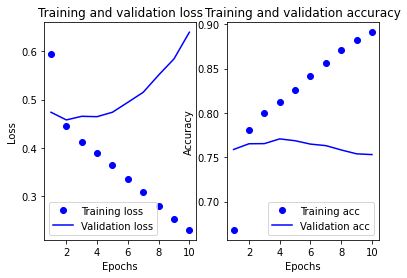

In [19]:
model_learning(model_CNN, 10)

Epoch 1/10
215/215 [==============================] - 1s 4ms/step - loss: 0.6173 - accuracy: 0.7157 - val_loss: 0.4885 - val_accuracy: 0.8029
Epoch 2/10
215/215 [==============================] - 1s 4ms/step - loss: 0.4114 - accuracy: 0.8254 - val_loss: 0.3788 - val_accuracy: 0.8340
Epoch 3/10
215/215 [==============================] - 1s 4ms/step - loss: 0.3458 - accuracy: 0.8529 - val_loss: 0.3604 - val_accuracy: 0.8421
Epoch 4/10
215/215 [==============================] - 1s 4ms/step - loss: 0.3155 - accuracy: 0.8682 - val_loss: 0.3563 - val_accuracy: 0.8448
Epoch 5/10
215/215 [==============================] - 1s 4ms/step - loss: 0.2938 - accuracy: 0.8781 - val_loss: 0.3570 - val_accuracy: 0.8447
Epoch 6/10
215/215 [==============================] - 1s 4ms/step - loss: 0.2760 - accuracy: 0.8873 - val_loss: 0.3616 - val_accuracy: 0.8450
Epoch 7/10
215/215 [==============================] - 1s 3ms/step - loss: 0.2614 - accuracy: 0.8949 - val_loss: 0.3678 - val_accuracy: 0.8435
Epoch 

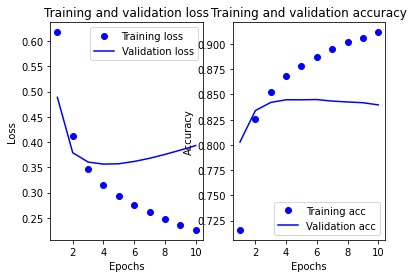

In [20]:
model_learning(model_CNN_simple, 10)

세가지 모델 중 RNN 모델이 가장 높은 accuracy(**0.8428**)를 보였다. 모든 모델이 2번째 epoch 이후 validation loss와 train loss의 차이가 벌어지고 있어 epoch의 수를 줄일 필요가 있다.

## 5. 학습된 Embedding 레이어 분석

In [21]:
embedding_layer = model_RNN.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(12000, 16)


In [22]:
import os

word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))
 
vectors = model_RNN.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

앞서 사용한 모든 모델은 같은 embedding 레이어를 썼다. 해당 레이어가 단어를 번역한 벡터를 word2vec.txt 파일에 기록해둔다.

In [23]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['사랑']
vector

array([ 0.07988749,  0.02130235,  0.06713093,  0.08106474, -0.09838212,
       -0.1103124 , -0.06056758, -0.08893662,  0.12444653, -0.05734354,
       -0.06831525,  0.14671439,  0.04683202, -0.06370616,  0.03606167,
        0.01228169], dtype=float32)

In [24]:
word_vectors.similar_by_word("사랑")

[('돌아보', 0.9589885473251343),
 ('케이온', 0.9577083587646484),
 ('반해', 0.9528346061706543),
 ('정혜', 0.9495851397514343),
 ('이루어지', 0.9491547346115112),
 ('반드시', 0.944381594657898),
 ('일품', 0.943852961063385),
 ('리슨', 0.9423803091049194),
 ('장인', 0.941343367099762),
 ('군사', 0.9406837224960327)]

gensim에서 제공하는 패키지를 이용해, 임베딩 레이어가 번역한 word vector를 읽어 '사랑'의 유의어를 호출했다. 의미적 유사도가 높다고 보기 어렵다.

## 6. 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [25]:
corpus = []

for sentence in train_data['document']:
    corpus.append(sentence) 
for sentence in test_data['document']:
    corpus.append(sentence)

In [26]:
tokenized_corpus = []

for sentence in corpus:
    temp_X = tokenizer.morphs(sentence) 
    tokenized_corpus.append(temp_X)

In [27]:
from gensim.models import Word2Vec
Word2vec = Word2Vec(sentences = tokenized_corpus, vector_size = 100, window = 2, min_count=5, workers=4, sg=1)

gensim word2vec는 단어마다 차례대로 인덱싱을 하여 벡터화 하지 않고, 유사한 단어들을 비슷한 방향과 힘의 벡터를 갖도록 단어를 벡터화 시켜주는 방법 중 하나이다. 
  * sentence: 단어 벡터를 만들 문장. (train과 test 문장들을 토큰화하여 입력하였다.)
  * vector_size: 단어 벡터의 차원 수
  * window: 주변 단어. (한 단어 주변의 앞뒤 2개까지를 고려한다.)
  * min_count: 최소 출현 빈도
  * workers: CPU 또는 GPU 코어의 수
  * sg: CBOW(Continuous Bag of Words) 또는 Skip-gram 방법 선택{0: CBOW 1: Skip-gram} 

코드 및 파라미터 설명 참조: [ratsgo's blog](https://ratsgo.github.io/natural%20language%20processing/2017/03/08/word2vec/), [딥 러닝을 이용한 자연어 처리 입문](https://wikidocs.net/50739)

In [38]:
type(Word2vec)

gensim.models.word2vec.Word2Vec

In [29]:
type(Word2vec.wv)

gensim.models.keyedvectors.KeyedVectors

In [39]:
type(Word2vec.wv.vectors)

numpy.ndarray

In [28]:
Word2vec.wv.vectors.shape

(18965, 100)

In [30]:
Word2vec.wv.most_similar('사랑')

[('이별', 0.6545360684394836),
 ('우정', 0.6495128870010376),
 ('고통', 0.6480737328529358),
 ('그리움', 0.6421448588371277),
 ('존경', 0.6403327584266663),
 ('일탈', 0.636834442615509),
 ('소망', 0.6292785406112671),
 ('성장', 0.6263066530227661),
 ('순수', 0.623364269733429),
 ('젊음', 0.6194230914115906)]

Word2vec 자체는 단어의 유사성을 이용해 단어를 벡터화시키는 '모델'이며, 단어와 생성된 벡터가 키(단어):값(벡터) 형식으로 구성되어 있는 객체는 Word2vec.wv 이다. 이를 통해 '사랑'의 유의어를 호출하면 연관된 단어들이 나타나는 것을 확인 할 수 있다.

In [31]:
vocab_size = 18965 
word_vector_dim = 100
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

def get_vector(word):
    if word in Word2vec.wv:
        return Word2vec.wv[word]
    else:
        return None

for word, i in word_to_index.items():
    temp = get_vector(word)
    if temp is not None:
        embedding_matrix[i] = temp

Word2vec를 embedding 레이어에 적용하기 위해 (단어의 수 × 단어의 차원 수) 행렬 embedding_matrix를 생성한다.

코드 참조: [Dev log: 삶은 확률의 구름](https://ebbnflow.tistory.com/153)

In [32]:
from tensorflow.keras.initializers import Constant


model_RNN_new = tf.keras.Sequential()
model_RNN_new.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, embeddings_initializer=Constant(embedding_matrix), 
                                            input_length=maxlen, trainable=True))
model_RNN_new.add(tf.keras.layers.LSTM(8))    
model_RNN_new.add(tf.keras.layers.Dense(8, activation = 'relu'))    
model_RNN_new.add(tf.keras.layers.Dense(1, activation = 'sigmoid')) 

model_RNN_new.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 100)           1896500   
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 3488      
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 1,900,069
Trainable params: 1,900,069
Non-trainable params: 0
_________________________________________________________________


Epoch 1/3
215/215 [==============================] - 3s 9ms/step - loss: 0.4553 - accuracy: 0.7961 - val_loss: 0.3602 - val_accuracy: 0.8463
Epoch 2/3
215/215 [==============================] - 2s 7ms/step - loss: 0.3354 - accuracy: 0.8581 - val_loss: 0.3380 - val_accuracy: 0.8547
Epoch 3/3
215/215 [==============================] - 2s 7ms/step - loss: 0.3031 - accuracy: 0.8747 - val_loss: 0.3375 - val_accuracy: 0.8565
1537/1537 - 3s - loss: 0.3452 - accuracy: 0.8507
[0.3451993465423584, 0.8507232069969177]


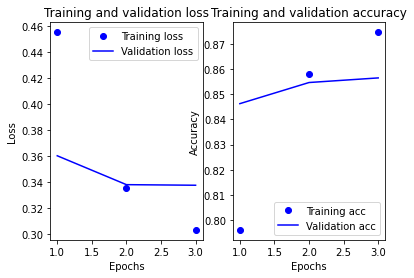

In [33]:
model_learning(model_RNN_new, 3)

In [34]:
model_CNN_new = tf.keras.Sequential()
model_CNN_new.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, embeddings_initializer=Constant(embedding_matrix), 
                                            input_length=maxlen, trainable=True)) 
model_CNN_new.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_CNN_new.add(tf.keras.layers.MaxPooling1D(5))
model_CNN_new.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_CNN_new.add(tf.keras.layers.GlobalMaxPooling1D())
model_CNN_new.add(tf.keras.layers.Dense(8, activation='relu'))
model_CNN_new.add(tf.keras.layers.Dense(1, activation='sigmoid'))


model_CNN_new.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 50, 100)           1896500   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 44, 16)            11216     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 8, 16)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 2, 16)             1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

Epoch 1/3
215/215 [==============================] - 2s 7ms/step - loss: 0.5637 - accuracy: 0.6838 - val_loss: 0.4741 - val_accuracy: 0.7621
Epoch 2/3
215/215 [==============================] - 1s 6ms/step - loss: 0.4506 - accuracy: 0.7754 - val_loss: 0.4695 - val_accuracy: 0.7598
Epoch 3/3
215/215 [==============================] - 1s 6ms/step - loss: 0.4184 - accuracy: 0.7959 - val_loss: 0.4525 - val_accuracy: 0.7731
1537/1537 - 3s - loss: 0.4577 - accuracy: 0.7704
[0.4576529860496521, 0.7703683972358704]


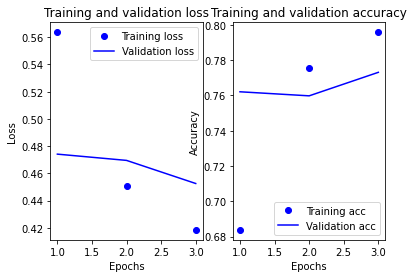

In [35]:
model_learning(model_CNN_new, 3)

In [36]:
model_CNN_simple_new = tf.keras.Sequential()
model_CNN_simple_new.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, embeddings_initializer=Constant(embedding_matrix),
                                                   input_length=maxlen, trainable=True))
model_CNN_simple_new.add(tf.keras.layers.GlobalMaxPooling1D())
model_CNN_simple_new.add(tf.keras.layers.Dense(8, activation='relu'))
model_CNN_simple_new.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_CNN_simple_new.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 50, 100)           1896500   
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 100)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 808       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 1,897,317
Trainable params: 1,897,317
Non-trainable params: 0
_________________________________________________________________


Epoch 1/3
215/215 [==============================] - 1s 5ms/step - loss: 0.6192 - accuracy: 0.6837 - val_loss: 0.5137 - val_accuracy: 0.7720
Epoch 2/3
215/215 [==============================] - 1s 4ms/step - loss: 0.4497 - accuracy: 0.7979 - val_loss: 0.4088 - val_accuracy: 0.8143
Epoch 3/3
215/215 [==============================] - 1s 4ms/step - loss: 0.3895 - accuracy: 0.8261 - val_loss: 0.3812 - val_accuracy: 0.8268
1537/1537 - 2s - loss: 0.3883 - accuracy: 0.8261
[0.3883158266544342, 0.8261488676071167]


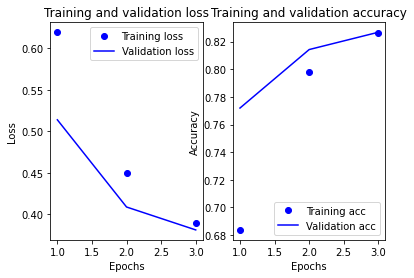

In [37]:
model_learning(model_CNN_simple_new, 3)

앞서 만들었던 세가지 모델의 embedding 레이어를 모두 변경하고 epochs를 3회로 줄여 학습을 진행한 결과, RNN 모델과 CNN 모델 accuracy에 조금의 향상이 있었다.(0.8428->**0.8507** / 0.7530->0.7704) 1-layer CNN 모델의 accuracy는 오히려 떨어졌다.(0.8375->0.8261) '전체 문장 중에서 단 하나의 가장 중요한 단어만 피처로 추출하여 문장의 긍정/부정을 평가하는 방식'으로 동작하는 1-layer CNN에 유사한 단어들을 통해 단어를 의미 벡터화하는 Word2vec embedding 레이어는 적합하지 않았음을 알 수 있다.

## 회고

- 세가지 모델 모두 비교적 높은 accuracy를 보였으나, Word2vec를 이용해 embedding 레이어를 개선하기 전과 후의 차이가 크지 않아, 루브릭 평가 기준인 85%는 넘겼지만 90% 이상으로 더 크게 개선하기 위해서는 어떤 방법을 시행해야 할지 고민이 된다. 
- 프로젝트 전 노드의 내용과 프로젝트 진행 경험을 비교해 유추하자면, 처음 텍스트를 인덱스화 할 때 설정한 단어의 수, 패딩 시에 결정하는 문장 길이에 모델의 성능이 크게 영향을 받는 것으로 보인다.
- 단어를 의미 벡터로 환원하여 모델이 학습할 수 있도록 변환하는 방식은 매우 흥미롭다. 단어가 벡터라면, 어떤 문장이 문장은 벡터들끼리의 합으로 정의될 수 있는지 상세한 개념이 궁금하다.
- 처음 embedding 레이어에는 벡터의 차원수를 16으로 제한했고, Word2vec를 이용했을 때는 차원을 100으로 늘렸다. 단어 벡터의 차원수가 높아지면 모델의 성능이 항상 더 좋아지는 지 아래 코드로 시험해본 결과, 차원수가 16이었을 때와 크게 다르지 않음을 확인 할 수 있다. 단어 벡터의 차원수가 높아지는 것이 꼭 모델이 단어를 잘 '이해'하는 것을 담보하지 않는다면, Word2vec에서 차원을 늘려야 했던 이유가 무엇이고, 더 적절한 차원수는 어떻게 찾을 수 있을지 궁금하다.

In [40]:
vocab_size = 12000   
word_vector_dim = 100

model_RNN_100 = tf.keras.Sequential()
model_RNN_100.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape = (None,)))
model_RNN_100.add(tf.keras.layers.LSTM(8))    
model_RNN_100.add(tf.keras.layers.Dense(8, activation = 'relu'))    
model_RNN_100.add(tf.keras.layers.Dense(1, activation = 'sigmoid')) 

model_RNN_100.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 100)         1200000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 8)                 3488      
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 1,203,569
Trainable params: 1,203,569
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
215/215 [==============================] - 3s 9ms/step - loss: 0.4552 - accuracy: 0.8031 - val_loss: 0.3536 - val_accuracy: 0.8483
Epoch 2/10
215/215 [==============================] - 1s 7ms/step - loss: 0.3244 - accuracy: 0.8652 - val_loss: 0.3480 - val_accuracy: 0.8507
Epoch 3/10
215/215 [==============================] - 1s 7ms/step - loss: 0.2937 - accuracy: 0.8793 - val_loss: 0.3454 - val_accuracy: 0.8518
Epoch 4/10
215/215 [==============================] - 1s 7ms/step - loss: 0.2719 - accuracy: 0.8905 - val_loss: 0.3446 - val_accuracy: 0.8529
Epoch 5/10
215/215 [==============================] - 1s 7ms/step - loss: 0.2514 - accuracy: 0.8997 - val_loss: 0.3531 - val_accuracy: 0.8522
Epoch 6/10
215/215 [==============================] - 1s 7ms/step - loss: 0.2311 - accuracy: 0.9090 - val_loss: 0.3615 - val_accuracy: 0.8528
Epoch 7/10
215/215 [==============================] - 1s 7ms/step - loss: 0.2126 - accuracy: 0.9181 - val_loss: 0.3783 - val_accuracy: 0.8512
Epoch 

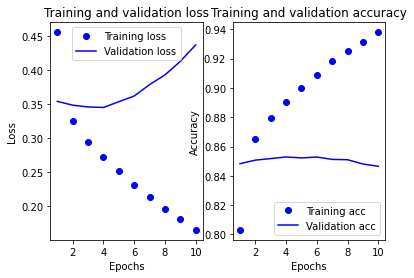

In [41]:
model_learning(model_RNN_100, 10)